In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FANG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,19.459999,19.920000,18.600000,19.240000,18.924437,189700
1,1/3/2013,19.240000,19.459999,18.650000,19.139999,18.826073,89100
2,1/4/2013,19.250000,20.490000,18.969999,20.049999,19.721148,173300
3,1/7/2013,19.889999,21.240000,19.639999,20.770000,20.429340,210300
4,1/8/2013,20.690001,21.100000,20.379999,20.600000,20.262127,229400


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 470.310048.3, cost: 0.036152, total money: 9550.710050
epoch: 20, total rewards: 72.359930.3, cost: 0.032326, total money: 9376.839933
epoch: 30, total rewards: 328.620066.3, cost: 0.012716, total money: 9973.370066
epoch: 40, total rewards: 276.020110.3, cost: 0.004942, total money: 9919.080107
epoch: 50, total rewards: -24.260018.3, cost: 0.002776, total money: 9884.429985
epoch: 60, total rewards: -258.719842.3, cost: 0.071856, total money: 9653.260162
epoch: 70, total rewards: 198.109931.3, cost: 0.010034, total money: 9843.139937
epoch: 80, total rewards: -51.490103.3, cost: 0.000610, total money: 9948.509897
epoch: 90, total rewards: 195.350003.3, cost: 0.003060, total money: 10104.280003
epoch: 100, total rewards: 137.180043.3, cost: 0.007251, total money: 10046.410046
epoch: 110

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 21.629999, total balance 9978.370001
day 7, sell 1 unit at price 21.670000, investment 0.184933 %, total balance 10000.040001,
day 15: buy 1 unit at price 21.430000, total balance 9978.610001
day 16, sell 1 unit at price 22.000000, investment 2.659821 %, total balance 10000.610001,
day 31: buy 1 unit at price 22.299999, total balance 9978.310001
day 32, sell 1 unit at price 22.820000, investment 2.331841 %, total balance 10001.130001,
day 33: buy 1 unit at price 21.280001, total balance 9979.850000
day 34, sell 1 unit at price 20.730000, investment -2.584592 %, total balance 10000.580000,
day 37: buy 1 unit at price 20.049999, total balance 9980.530001
day 38, sell 1 unit at price 20.959999, investment 4.538653 %, total balance 10001.490000,
day 46: buy 1 unit at price 24.490000, total balance 9977.000000
day 47, sell 1 unit at price 24.930000, investment 1.796654 %, total balance 10001.930000,
day 48: buy 1 unit at price 25.750000, total balance 9976.180000


day 338, sell 1 unit at price 75.720001, investment 3.372015 %, total balance 10015.959997,
day 341: buy 1 unit at price 72.720001, total balance 9943.239996
day 342, sell 1 unit at price 73.730003, investment 1.388892 %, total balance 10016.969999,
day 349: buy 1 unit at price 73.029999, total balance 9943.940001
day 350, sell 1 unit at price 72.779999, investment -0.342325 %, total balance 10016.719999,
day 362: buy 1 unit at price 83.839996, total balance 9932.880003
day 363, sell 1 unit at price 84.690002, investment 1.013843 %, total balance 10017.570005,
day 364: buy 1 unit at price 87.949997, total balance 9929.620008
day 365, sell 1 unit at price 89.900002, investment 2.217174 %, total balance 10019.520010,
day 368: buy 1 unit at price 89.050003, total balance 9930.470007
day 370, sell 1 unit at price 91.410004, investment 2.650197 %, total balance 10021.880011,
day 375: buy 1 unit at price 88.800003, total balance 9933.080008
day 377, sell 1 unit at price 88.290001, investment

day 752: buy 1 unit at price 65.430000, total balance 9959.779993
day 753, sell 1 unit at price 66.440002, investment 1.543638 %, total balance 10026.219995,
day 754: buy 1 unit at price 66.019997, total balance 9960.199999
day 756: buy 1 unit at price 66.110001, total balance 9894.089998
day 757: buy 1 unit at price 65.190002, total balance 9828.899996
day 758, sell 1 unit at price 62.200001, investment -5.786119 %, total balance 9891.099997,
day 759: buy 1 unit at price 60.400002, total balance 9830.699995
day 760: buy 1 unit at price 60.759998, total balance 9769.939997
day 761, sell 1 unit at price 57.599998, investment -12.872488 %, total balance 9827.539995,
day 762, sell 1 unit at price 58.520000, investment -10.231633 %, total balance 9886.059996,
day 763, sell 1 unit at price 59.509998, investment -1.473515 %, total balance 9945.569994,
day 764, sell 1 unit at price 62.680000, investment 3.159977 %, total balance 10008.249994,
day 767: buy 1 unit at price 60.910000, total bala

day 1085: buy 1 unit at price 103.970001, total balance 9906.430006
day 1086, sell 1 unit at price 103.209999, investment -0.730982 %, total balance 10009.640005,
day 1090: buy 1 unit at price 98.379997, total balance 9911.260008
day 1091, sell 1 unit at price 100.279999, investment 1.931288 %, total balance 10011.540007,
day 1097: buy 1 unit at price 101.379997, total balance 9910.160009
day 1100, sell 1 unit at price 103.959999, investment 2.544882 %, total balance 10014.120008,
day 1103: buy 1 unit at price 103.120003, total balance 9911.000006
day 1104, sell 1 unit at price 102.250000, investment -0.843680 %, total balance 10013.250006,
day 1158: buy 1 unit at price 94.980003, total balance 9918.270002
day 1159, sell 1 unit at price 94.580002, investment -0.421143 %, total balance 10012.850004,
day 1165: buy 1 unit at price 86.099998, total balance 9926.750006
day 1166, sell 1 unit at price 87.260002, investment 1.347275 %, total balance 10014.010008,
day 1175: buy 1 unit at price 

day 1537, sell 1 unit at price 97.860001, investment 1.304350 %, total balance 10060.179960,
day 1540: buy 1 unit at price 103.830002, total balance 9956.349959
day 1541: buy 1 unit at price 105.500000, total balance 9850.849959
day 1542, sell 1 unit at price 104.800003, investment 0.934221 %, total balance 9955.649962,
day 1543, sell 1 unit at price 106.449997, investment 0.900471 %, total balance 10062.099959,
day 1548: buy 1 unit at price 105.489998, total balance 9956.609961
day 1549, sell 1 unit at price 102.930000, investment -2.426768 %, total balance 10059.539961,
day 1552: buy 1 unit at price 102.620003, total balance 9956.919958
day 1553, sell 1 unit at price 100.050003, investment -2.504385 %, total balance 10056.969961,
day 1554: buy 1 unit at price 97.760002, total balance 9959.209959
day 1556, sell 1 unit at price 97.580002, investment -0.184125 %, total balance 10056.789961,
day 1565: buy 1 unit at price 101.370003, total balance 9955.419958
day 1566, sell 1 unit at pric

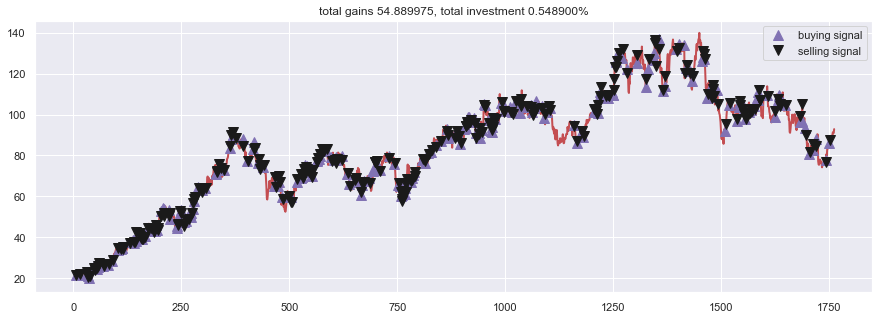

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()